<a href="https://colab.research.google.com/github/bachvu98/Data-Mining/blob/main/Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Epitopes Classification

## Problem Statement

The goal of this report is to present a fully developed data mining solution whilst showing the whole process of its development. All observations in our data are related to linear B-Cell epitopes, which are protein regions of interest for a variety of applications in immunology. The goal is to develop a
classification model to predict the class of new, previously unseen observations with the
best possible classification performance.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, GroupKFold, GroupShuffleSplit
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer
import keras
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

## Get Data

Read in the file. This dataset contains 4907 rows and 451 columns. Out of which one is dependent variable and rest 450 are independent variables — physico-chemical characteristics.

In [7]:
df = pd.read_csv('https://raw.githubusercontent.com/bachvu98/Data-Mining/main/CW_data.csv')
df

,Info_PepID,Info_protein_id,Info_center_pos,Info_AA,Info_window_seq,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,...,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y,Class
0,AAA99570.1:2,AAA99570.1,17,D,NQTTVKADSDNNRSA,3.056565,62,133,23,42,0,1872.85,0.400000,0.800000,0.200000,0.0,0.200000,0.800000,0.266667,0.133333,0.133333,0.356000,-0.528667,0.135333,0.151333,-0.395333,0.035333,0.658667,-0.156000,-0.131333,-0.344667,-0.083333,0.096000,-0.332000,1.922667,-0.211333,-0.048667,-0.870667,0.683333,-0.739400,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.200000,0.000000,0.066667,0.066667,0.133333,0.133333,0.066667,0.0,0.0,1
1,AAA99570.1:2,AAA99570.1,18,S,QTTVKADSDNNRSAS,3.056565,61,132,22,42,0,1845.82,0.466667,0.800000,0.200000,0.0,0.200000,0.800000,0.266667,0.133333,0.133333,0.328667,-0.545333,0.172000,0.129333,-0.462667,0.054000,0.632667,-0.182000,-0.184667,-0.464667,-0.242000,-0.042000,-0.232000,1.878667,-0.390667,-0.041333,-0.886667,0.620667,-0.705133,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.133333,0.000000,0.066667,0.066667,0.200000,0.133333,0.066667,0.0,0.0,1
2,AAA99570.1:2,AAA99570.1,19,D,TTVKADSDNNRSASV,2.923231,61,133,21,41,0,1816.82,0.466667,0.866667,0.266667,0.0,0.266667,0.733333,0.266667,0.133333,0.133333,0.210000,-0.554000,0.188000,0.111333,-0.526000,0.185333,0.532667,-0.222000,-0.278000,-0.592000,-0.190667,-0.070667,-0.033333,1.589333,-0.600000,-0.048000,-0.854000,0.575333,-0.735267,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.066667,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.133333,0.133333,0.0,0.0,1
3,AAA99570.1:2,AAA99570.1,20,N,TVKADSDNNRSASVK,2.923231,63,138,22,40,0,1843.89,0.400000,0.800000,0.266667,0.0,0.266667,0.733333,0.333333,0.200000,0.133333,0.223333,-0.504667,0.230000,0.071333,-0.424667,0.089333,0.604000,-0.112667,-0.400000,-0.531333,-0.119333,-0.065333,-0.006000,1.692000,-0.395333,-0.139333,-0.657333,0.622667,-0.825600,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.133333,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.066667,0.133333,0.0,0.0,1
4,AAA99570.1:2,AAA99570.1,21,N,VKADSDNNRSASVKK,2.739572,65,143,23,39,0,1870.96,0.333333,0.733333,0.266667,0.0,0.266667,0.733333,0.400000,0.266667,0.133333,0.236667,-0.455333,0.272000,0.031333,-0.323333,-0.006667,0.675333,-0.003333,-0.522000,-0.470667,-0.048000,-0.060000,0.021333,1.794667,-0.190667,-0.230667,-0.460667,0.670000,-0.915933,...,0.0,0.0,0.076923,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.133333,0.0,0.133333,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.000000,0.0,0.133333,0.000000,0.000000,0.066667,0.200000,0.000000,0.133333,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

Dataset has only float, integer and object values. No variable column has null/missing values.

# Exploratory Data Analysis

Describe the summary statistics for the features

In [8]:
df.describe()

,Info_center_pos,feat_seq_entropy,feat_C_atoms,feat_H_atoms,feat_N_atoms,feat_O_atoms,feat_S_atoms,feat_molecular_weight,feat_Perc_Tiny,feat_Perc_Small,feat_Perc_Aliphatic,feat_Perc_Aromatic,feat_Perc_NonPolar,feat_Perc_Polar,feat_Perc_Charged,feat_Perc_Basic,feat_Perc_Acidic,feat_PP1,feat_PP2,feat_PP3,feat_KF1,feat_KF2,feat_KF3,feat_KF4,feat_KF5,feat_KF6,feat_KF7,feat_KF8,feat_KF9,feat_KF10,feat_Z1,feat_Z2,feat_Z3,feat_Z4,feat_Z5,feat_F1,feat_F2,feat_F3,feat_F4,feat_F5,...,feat_CT642,feat_CT643,feat_CT644,feat_CT645,feat_CT646,feat_CT650,feat_CT651,feat_CT652,feat_CT653,feat_CT654,feat_CT655,feat_CT656,feat_CT660,feat_CT661,feat_CT662,feat_CT663,feat_CT664,feat_CT665,feat_CT666,feat_Perc_A,feat_Perc_C,feat_Perc_D,feat_Perc_E,feat_Perc_F,feat_Perc_G,feat_Perc_H,feat_Perc_I,feat_Perc_K,feat_Perc_L,feat_Perc_M,feat_Perc_N,feat_Perc_P,feat_Perc_Q,feat_Perc_R,feat_Perc_S,feat_Perc_T,feat_Perc_V,feat_Perc_W,feat_Perc_Y,Class
count,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,...,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.0,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000,4907.000000
mean,237.800285,2.967125,71.138170,145.627063,20.143061,38.892399,0.144080,1910.216108,0.309014,0.527763,0.291108,0.058420,0.431397,0.568603,0.316555,0.157041,0.159514,0.031674,-0.385500,0.045714,-0.166198,-0.265832,-0.147853,0.316094,-0.094627,-0.419413,-0.039130,-0.111248,-0.048050,-0.026923,0.666622,-0.491523,-0.331989,-0.620221,0.437229,-0.424951,0.095081,-0.231626,0.470484,0.117844,...,0.003574,0.003292,0.004875,0.004844,0.003809,0.007101,0.0,0.006020,0.002022,0.003464,0.003684,0.004060,0.003182,0.0,0.004233,0.003041,0.002978,0.005800,0.002728,0.108702,0.001223,0.067251,0.092263,0.016181,0.044671,0.016752,0.035147,0.106433,0.089600,0.008383,0.049494,0.044345,0.048135,0.033856,0.088364,0.066055,0.057659,0.003736,0.021751,-0.393112
std,261.151590,0.288593,6.766207,11.067443,2.832085,3.027500,0.401062,124.781144,0.145743,0.173096,0.126031,0.072698,0.147883,0.147883,0.164906,0.097903,0.109097,0.247882,0.122471,0.154564,0.346892,0.288143,0.288041,0.280712,0.250174,0.209948,0.293780,0.325023,0.195777,0.248213,0.726510,0.524818,0.406264,0.355932,0.229052,0.266743,0.351862,0.222181,0.214176,0.288024,...,0.016488,0.016692,0.019439,0.019508,0.017329,0.022805,0.0,0.021237,0.012308,0.016909,0.017146,0.017956,0.015709,0.0,0.018739,0.015388,0.015939,0.021468,0.014971,0.089586,0.008946,0.065131,0.094811,0.034078,0.059568,0.035628,0.049063,0.081071,0.073266,0.025351,0.060004,0.068443,0.055030,0.053778,0.084013,0.069178,0.063231,0.016419,0.043248,0.919584
min,1.000000,1.705587,47.000000,110.000000,15.000000,30.000000,0.000000,1499.560000,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.000000,0.000000,0.000000,-0.760000,-0.716667,-0.442667,-1.268000,-1.206667,-0.924000,-0.749333,-0.829333,-1.188000,-1.042000,-1.196667,-0.816000,-1.010667,-2.766667,-2.494000,-1.775333,-1.593333,-0.533333,-1.267333,-1.011867,-1.034667,-0.221067,-0.548200,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

Number of unique attributes

In [ ]:
df.nunique(axis=0)

Info_PepID          194
Info_protein_id     103
Info_center_pos     908
Info_AA              20
Info_window_seq    4013
                   ... 
feat_Perc_T           7
feat_Perc_V           7
feat_Perc_W           3
feat_Perc_Y           5
Class                 2
Length: 451, dtype: int64

Check for missing data. The dataset has no missing value

In [ ]:
df.isnull().values.any()

False

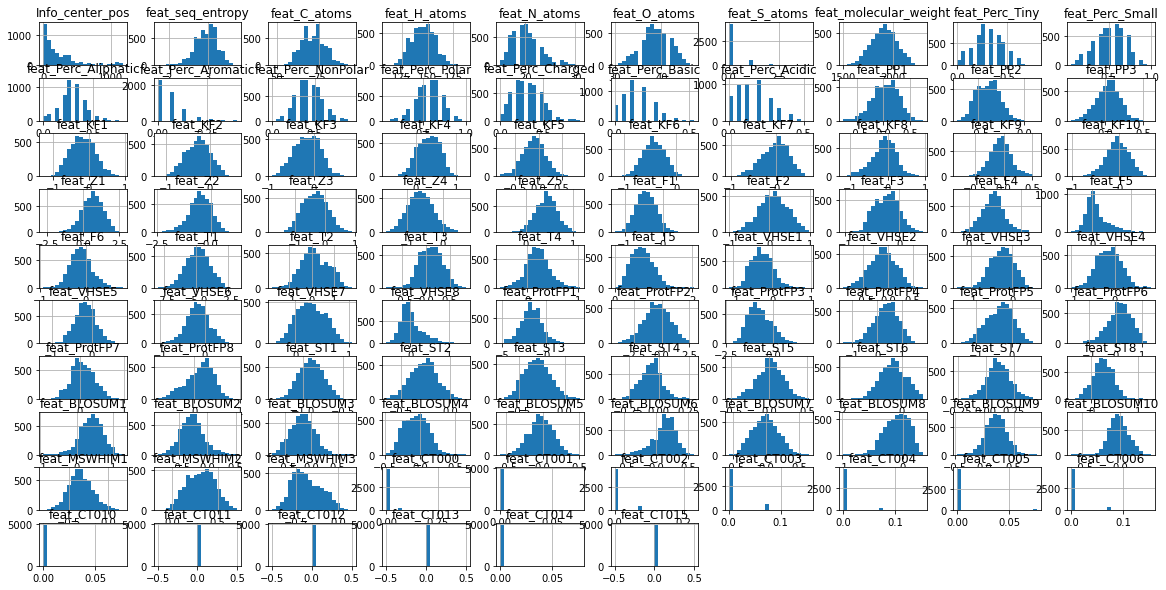

In [150]:
df.iloc[:,:100].hist(bins=20, figsize=(20,10));

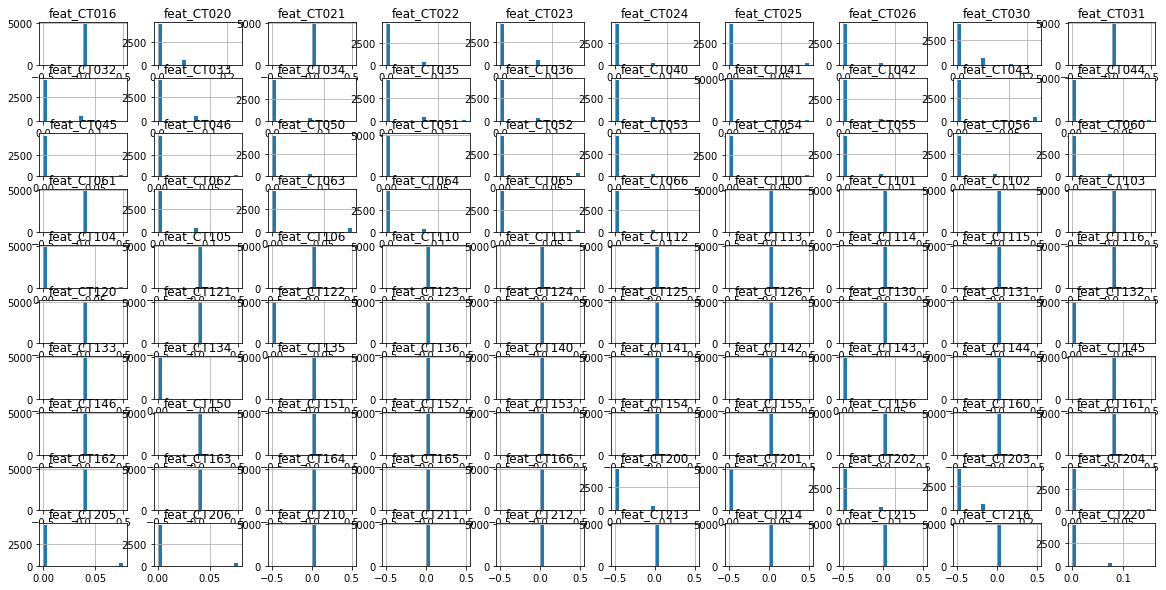

In [136]:
df.iloc[:,100:200].hist(bins=20, figsize=(20,10));

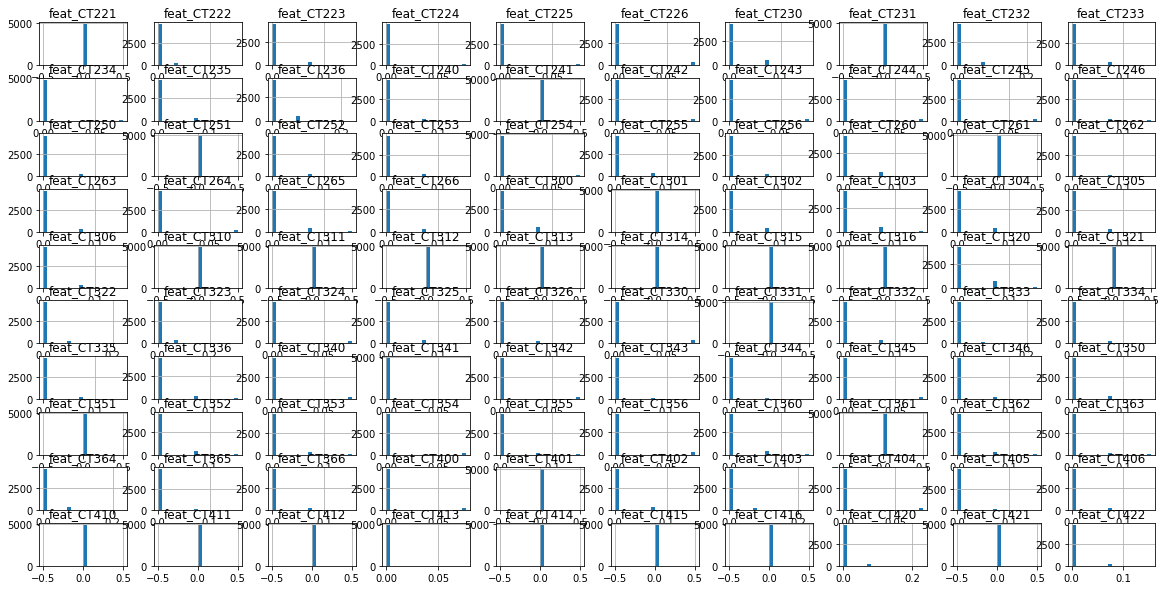

In [137]:
df.iloc[:,200:300].hist(bins=20, figsize=(20,10));

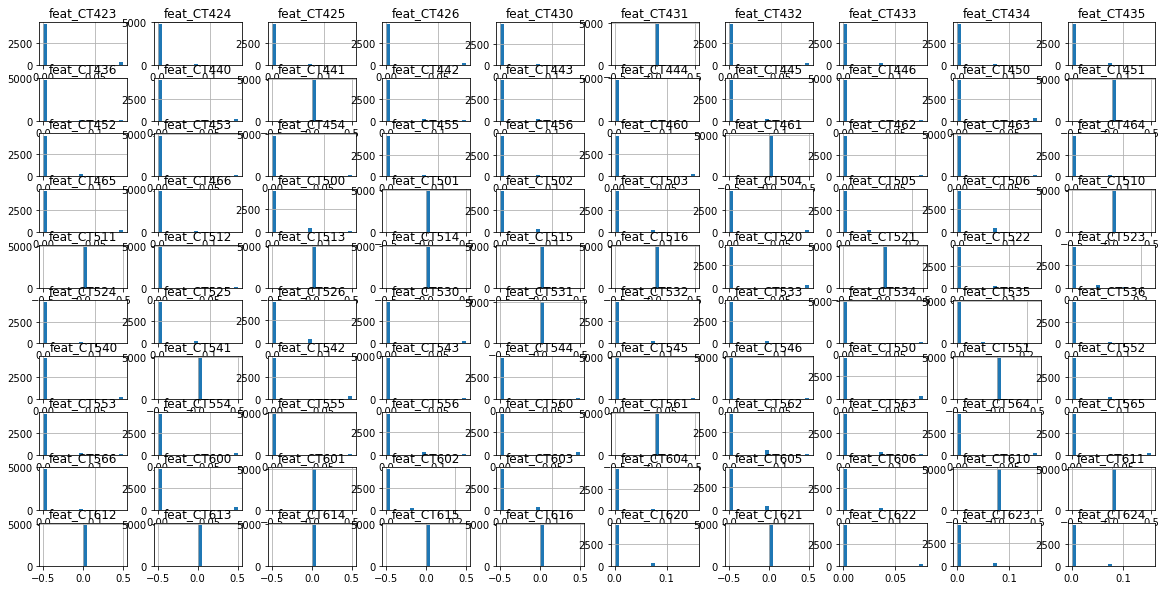

In [138]:
df.iloc[:,300:400].hist(bins=20, figsize=(20,10));

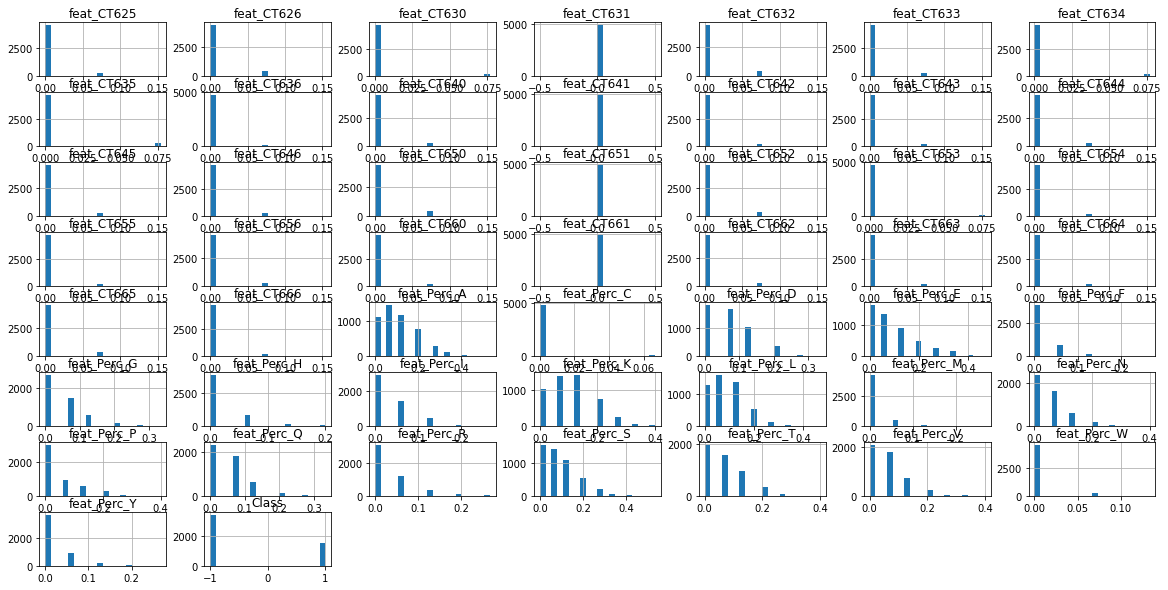

In [139]:
df.iloc[:,400:451].hist(bins=20, figsize=(20,10));

Boxplot of the features in the dataset. Feature molecular weight has a higher value range compared to other features

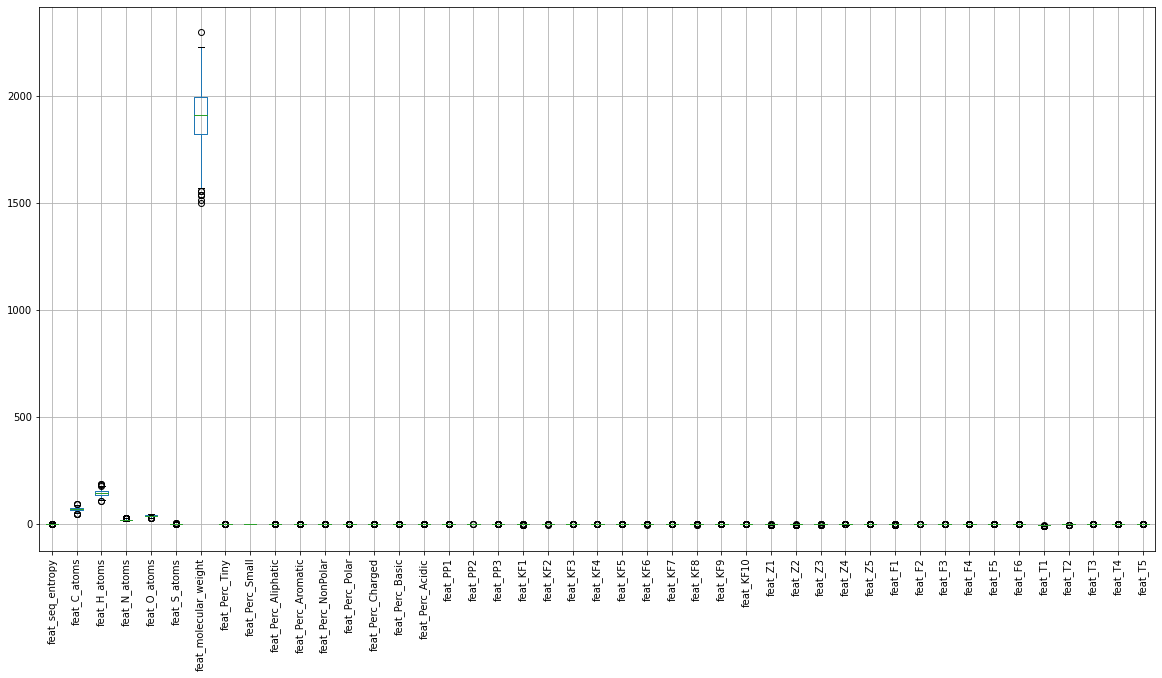

In [183]:
df.iloc[:,5:50].boxplot(rot=90, figsize=(20,10));

Other features in the dataset have a lower value and mostly have a mean of zero

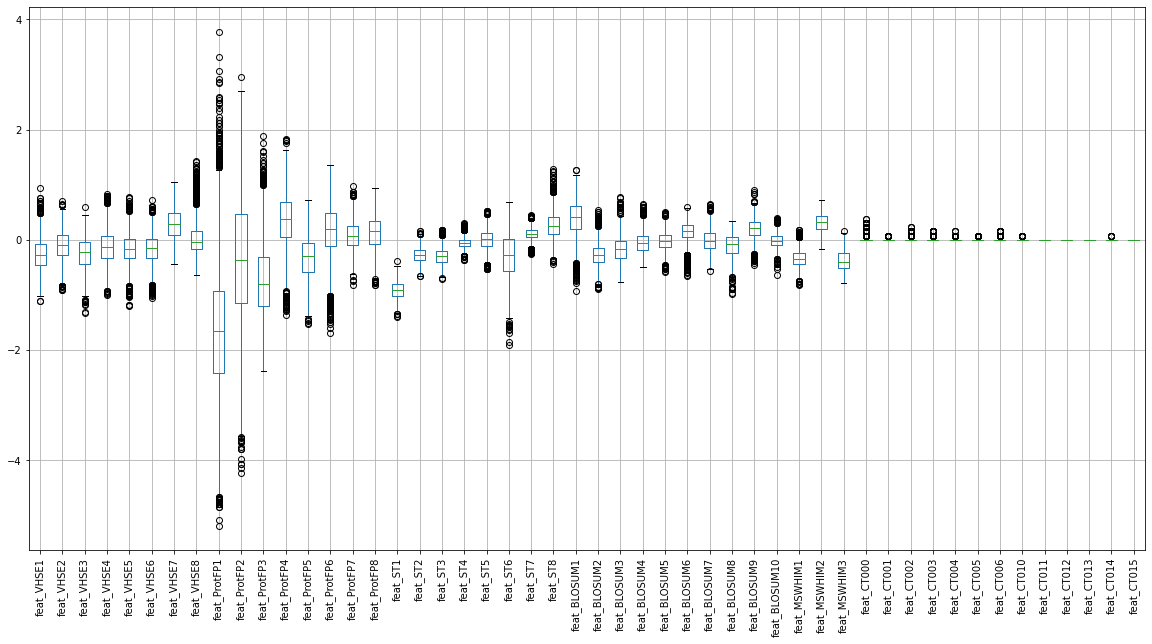

In [3]:
df.iloc[:,50:100].boxplot(rot=90, figsize=(20,10));

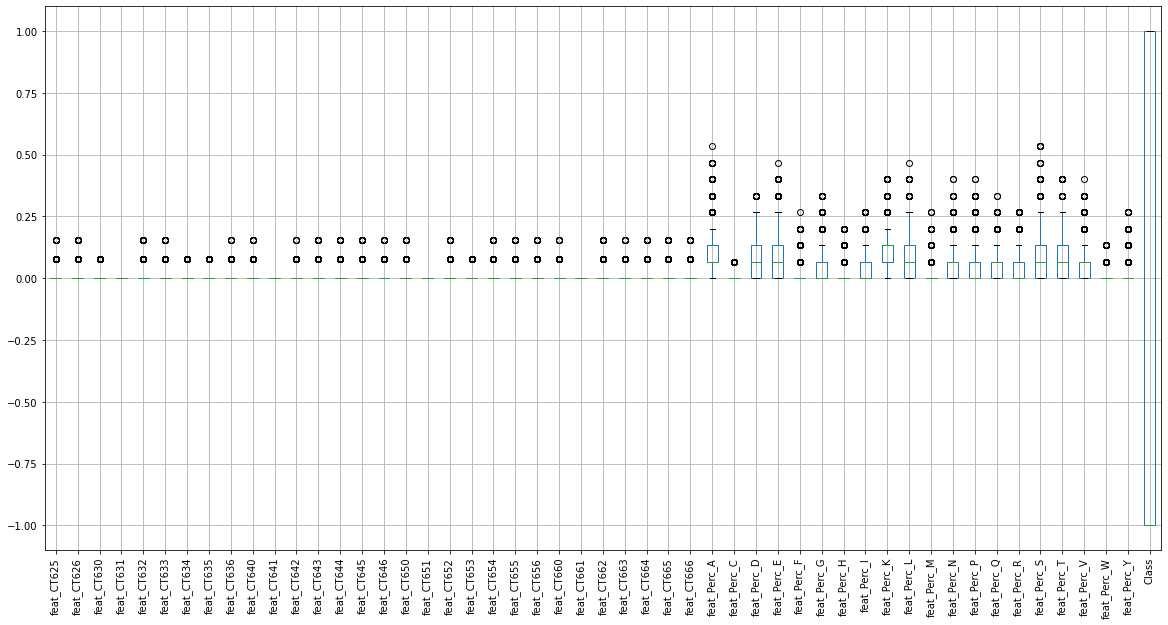

In [4]:
df.iloc[:,400:451].boxplot(rot=90, figsize=(20,10));

In [36]:
# Input
X = df.iloc[:,5:450]

# Target
y = df.iloc[:,450]

# Data Preprocessing

## Data Imputation

Since we don't have any missing value, we skip this step.

## Data Removal

Some columns in the datset contains only a single value. They don't contribute to the prediction of class so they will be removed.

In [37]:
X.drop([e for e in X.columns if X[e].nunique() == 1], axis=1, inplace=True)
len(X.columns)

332

## Treatment of Outliers

In [ ]:
#Capping the outlier rows with Percentiles
for col in X.columns:
  upper_lim = X[col].quantile(.95)
  lower_lim = X[col].quantile(.05)
  X.loc[(df[col] > upper_lim),col] = upper_lim
  X.loc[(df[col] < lower_lim),col] = lower_lim

## Log Transformation

Most of the time, dataset features do not follow a normal distribution. And since many machine learning models assume that condition, we need to find ways to meet it. The log transformation is, arguably, the most popular among the different types of transformations used to transform skewed data to approximately conform to normality

In [38]:
X.to_numpy().min()

-8.02466666666667

The min value of whole dataset is -8.02, so in order to apply log transformation, we need to add a constant to the dataset so that the min value is positive.

In [39]:
X = np.log(X+8.1)

## Scaling

Feature scaling is essential for machine learning algorithms that calculate distances between data. If not scale, the feature with a higher value range starts dominating when calculating distances. Algorithms sensitive to feature magnitude are KNN, Support Vector Machine and Neural Network

In [40]:
X_std = StandardScaler().fit_transform(X)
X = pd.DataFrame(X_std, index=X.index, columns=X.columns)

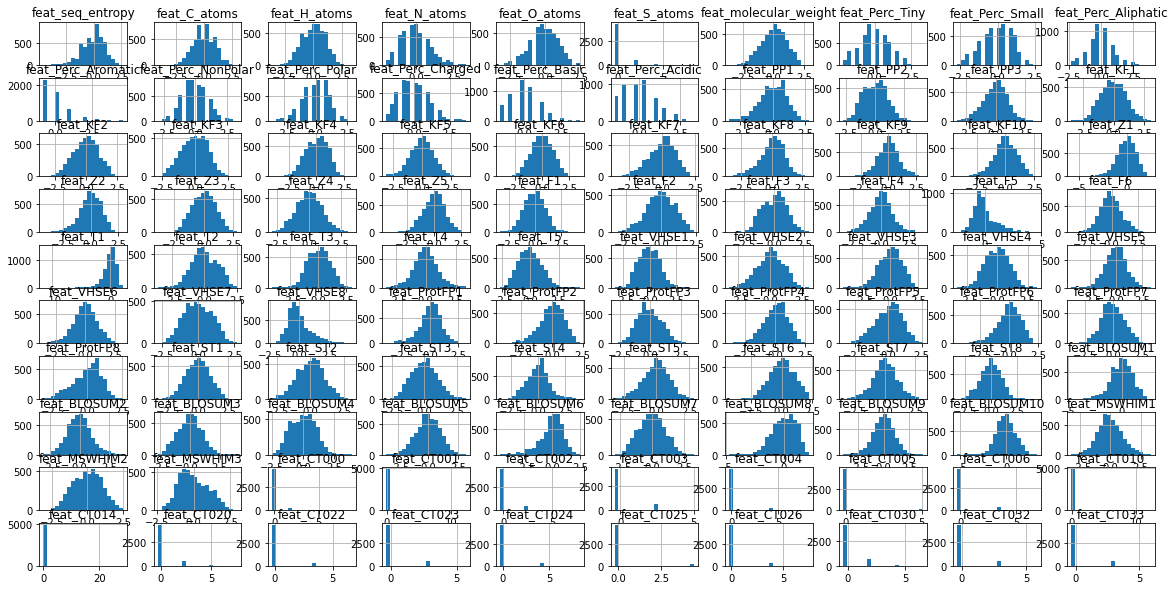

In [201]:
X.iloc[:,:100].hist(bins=20, figsize=(20,10));

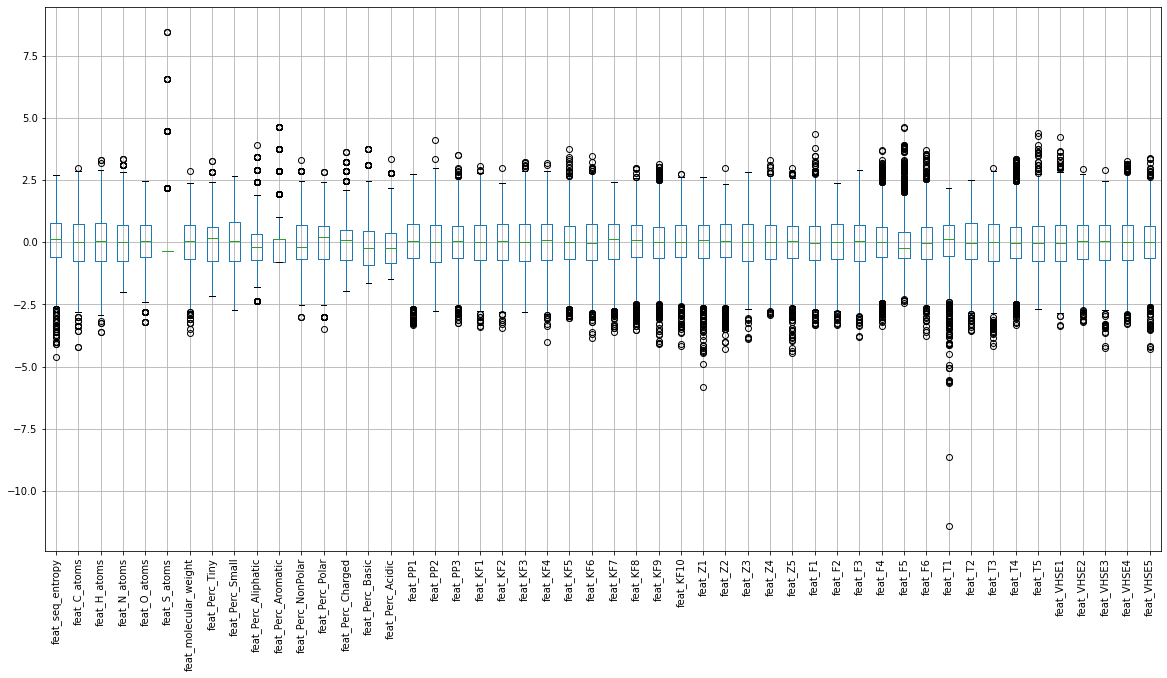

In [202]:
X.iloc[:,:50].boxplot(rot=90, figsize=(20,10));

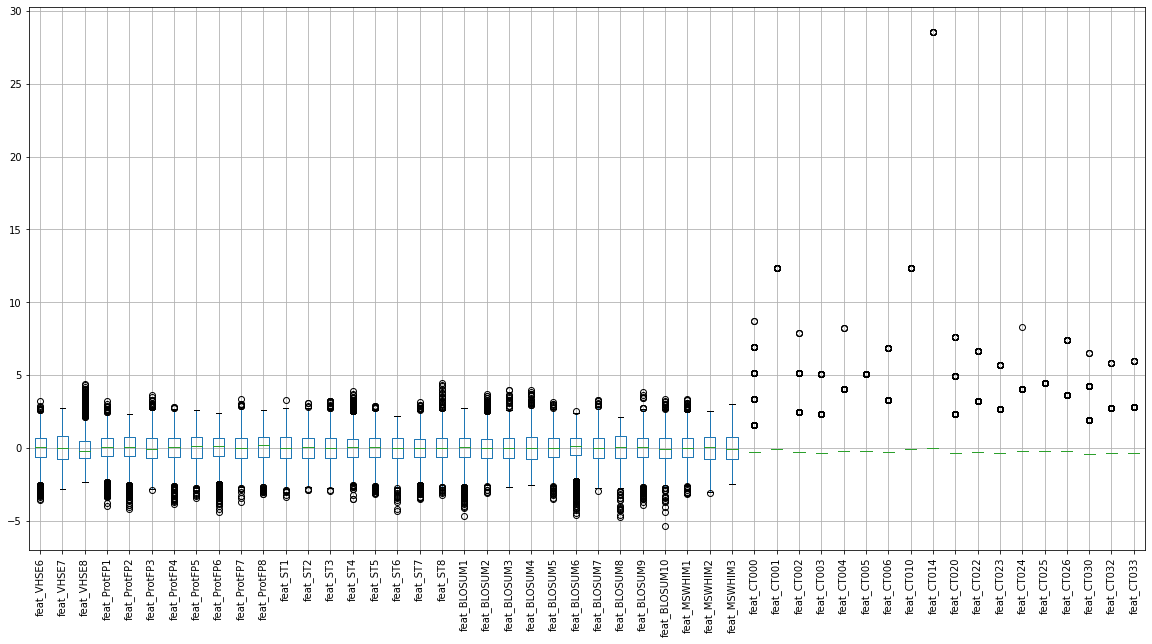

In [203]:
X.iloc[:,50:100].boxplot(rot=90, figsize=(20,10));

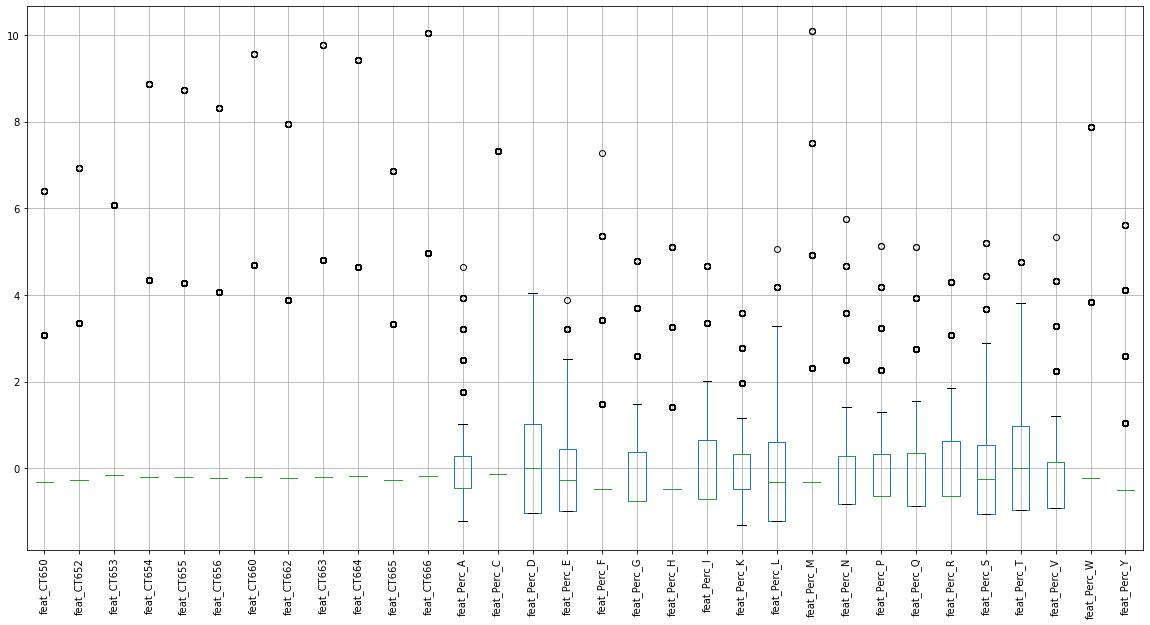

In [204]:
X.iloc[:,300:332].boxplot(rot=90, figsize=(20,10));

# Feature extraction and selection approaches

In [41]:
pca = PCA(n_components=0.99, random_state=0)

In [42]:
pca.fit(X_std)
principalComponents = pca.transform(X_std)
X = pd.DataFrame(data = principalComponents)

Applying PCA reduce the number of components to 136, which explain 99% information of the original dataset

In [43]:
print(pca.n_components_)
print(sum(pca.explained_variance_ratio_))

205
0.9900572650635691


# Class Imbalance

The data set is imbalanced; of the total records 3418 (69.66 %) had the class “0” and 1489 records (30.34 %) had the outcome “1” for the class output attribute

In [44]:
y.value_counts()

-1    3418
 1    1489
Name: Class, dtype: int64

In [45]:
print('\nBalance of positive and negative classes (%):')
y.value_counts(normalize=True) * 100


Balance of positive and negative classes (%):


-1    69.655594
 1    30.344406
Name: Class, dtype: float64

We apply SMOTE to balanced the dataset. SMOTE (Synthetic Minority Over-Sampling technique) shows good results in various applications. SMOTE adds artificially generated data which has the same character as the distribution of the minority class by over-sample the minority classes of the dataset through generating synthetic examples rather than over-sampling with replacement. Applying SMOTE to preprocess the data might improve the classification performance of the classifiers, however, it also introduces additional computational costs of data preprocessing. Oversampling also may cause classifiers to suffer from overfitting if not applied correctly.

# Model Training and Evaludation

In [46]:
y = y.replace(-1, 0)

Split the training and testing sets bsaed on the **Info_PepID** values

In [47]:
groups = df['Info_PepID'].values
gss = GroupShuffleSplit(n_splits=5, train_size=0.8, random_state=0)
train_inds, test_inds =  next(gss.split(X, y, groups=groups))
X_train, X_test, y_train, y_test = X.iloc[train_inds], X.iloc[test_inds], y[train_inds], y[test_inds]

Define our custom Matthews Correlation Coefficient

In [48]:
ftwo_scorer = make_scorer(matthews_corrcoef)

Balance of positive and negative classes in our training set

In [49]:
y_train.value_counts(normalize=True) * 100

0    68.9029
1    31.0971
Name: Class, dtype: float64

Balance of positive and negative classes in our testing set

In [50]:
y_test.value_counts(normalize=True) * 100

0    72.823779
1    27.176221
Name: Class, dtype: float64

The process is to determine which hyper-parameters to tune and their search space, adjust them from coarse to fine, evaluate the performance of 3 model: KNN, Support Vector Machine, XGBoost with different parameter sets, and determine the optimal combination. The search is conducted using a coarse to fine strategy: use a few parameter to quickly filter out the bad parameters; then use more  to search around the promising parameters. The diagrams below are showing the final result after fine tuning hyperparameter space.

## K-Nearest Neighbours

### Baseline Model

Done training in 38.12269330024719 seconds.
Best Parameter:  {'n_neighbors': 40}
Mean Test Score:  0.546760445923981
Sd Test Score:  0.21021523712448056


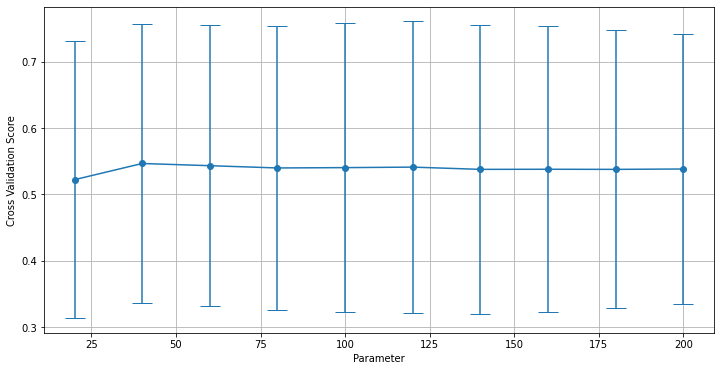

In [52]:
model = KNeighborsClassifier()
start_time = time.time()
kf = GroupKFold(n_splits=10)
group = df.iloc[X_train.index]['Info_PepID'].values
knnparams = {"n_neighbors": range(20,220,20)}
clf = GridSearchCV(model, knnparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_n_neighbors'].data
# collect test scores
results['test'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (8, 6)
plt.xticks(results['parameter'].astype(np.float))
plt.errorbar(results['parameter'].astype(np.float), results['test'], yerr=clf.cv_results_['std_test_score'], fmt='-o', capsize = 10)
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


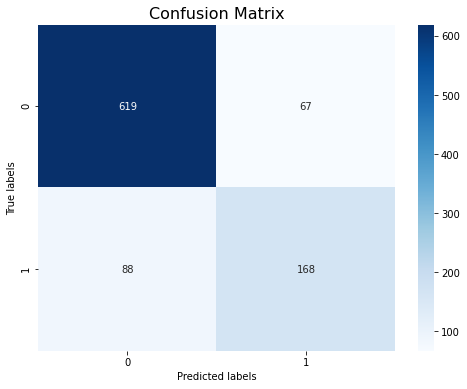

              precision    recall  f1-score   support

           0       0.88      0.90      0.89       686
           1       0.71      0.66      0.68       256

    accuracy                           0.84       942
   macro avg       0.80      0.78      0.79       942
weighted avg       0.83      0.84      0.83       942

MCC Score=0.574


In [56]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Done training in 88.98526978492737 seconds.
Best Parameter:  {'kneighborsclassifier__n_neighbors': 200}
Mean Test Score:  0.505765926701933
Sd Test Score:  0.12886149728597734


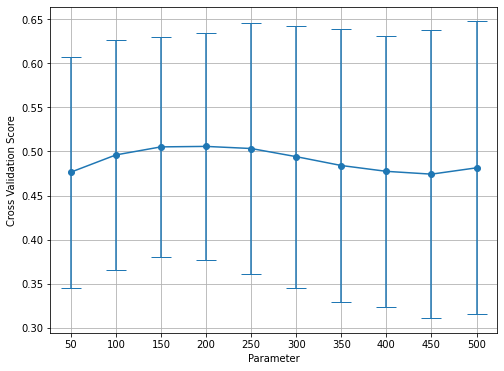

In [59]:
imba_pipeline = make_pipeline(SMOTE(random_state=0), KNeighborsClassifier())
start_time = time.time()
kf = GroupKFold(n_splits=10)
group = df.iloc[X_train.index]['Info_PepID'].values
params = {"n_neighbors": range(50,550,50)}
new_params = {'kneighborsclassifier__' + key: params[key] for key in params}
clf = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=ftwo_scorer,n_jobs=-1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_kneighborsclassifier__n_neighbors'].data
# collect test scores
results['test'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (8, 6)
plt.xticks(results['parameter'].astype(np.float))
plt.errorbar(results['parameter'].astype(np.float), results['test'], yerr=clf.cv_results_['std_test_score'], fmt='-o', capsize = 10)
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


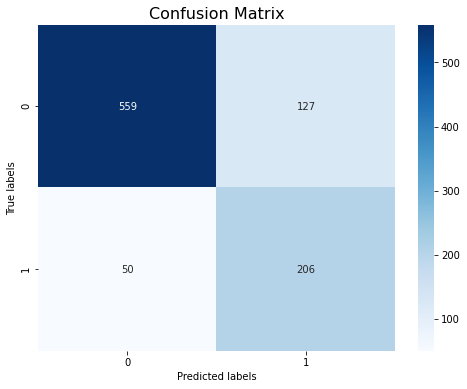

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       686
           1       0.62      0.80      0.70       256

    accuracy                           0.81       942
   macro avg       0.77      0.81      0.78       942
weighted avg       0.84      0.81      0.82       942

MCC Score=0.577


In [60]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

## Support Vector Machine

### Baseline Model

Done training in 97.26714038848877 seconds.
Best Parameter:  {'C': 0.15000000000000002}
Mean Test Score:  0.5538046146138316
Sd Test Score:  0.23599746792659326


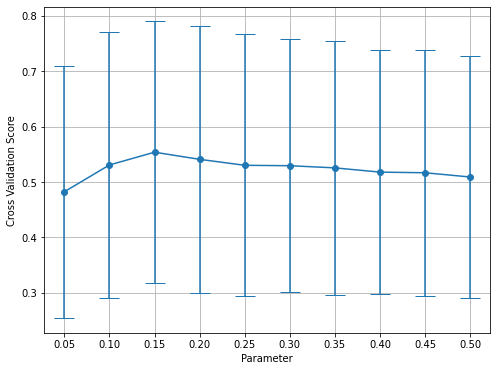

In [64]:
model = SVC(random_state=0)
start_time = time.time()
kf = GroupKFold(n_splits=10)
group = df.iloc[X_train.index]['Info_PepID'].values
svcparams = {'C': np.linspace(0.05,0.5,10)} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['test'] = clf.cv_results_['mean_test_score'].data


plt.rcParams['figure.figsize'] = (8, 6)
plt.xticks(results['parameter'].astype(np.float))
plt.errorbar(results['parameter'].astype(np.float), results['test'], yerr=clf.cv_results_['std_test_score'], fmt='-o', capsize = 10)
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


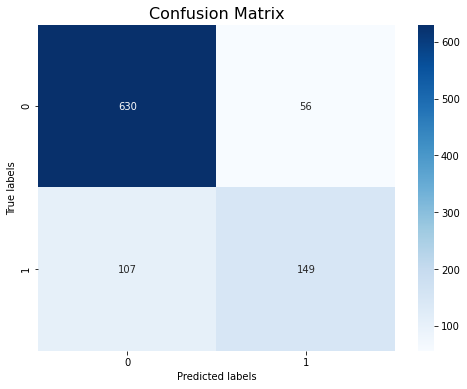

              precision    recall  f1-score   support

           0       0.85      0.92      0.89       686
           1       0.73      0.58      0.65       256

    accuracy                           0.83       942
   macro avg       0.79      0.75      0.77       942
weighted avg       0.82      0.83      0.82       942

MCC Score=0.539


In [65]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### Cost Sensitive

Done training in 171.389502286911 seconds.
Best Parameter:  {'C': 0.07}
Mean Test Score:  0.565751080921703
Sd Test Score:  0.19386699578781144


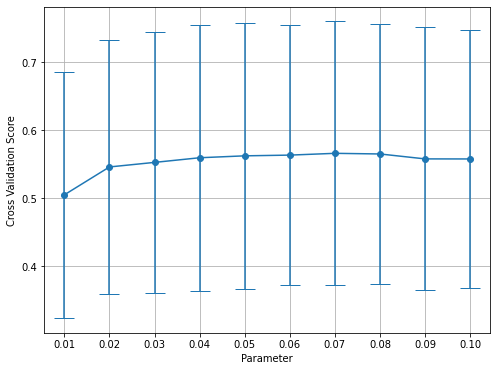

In [67]:
model = SVC(random_state=0, class_weight = 'balanced')
start_time = time.time()
kf = GroupKFold(n_splits=10)
group = df.iloc[X_train.index]['Info_PepID'].values
svcparams = {'C': np.linspace(0.01,0.1,10)} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['test'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (8, 6)
plt.xticks(results['parameter'].astype(np.float))
plt.errorbar(results['parameter'].astype(np.float), results['test'], yerr=clf.cv_results_['std_test_score'], fmt='-o', capsize = 10)
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


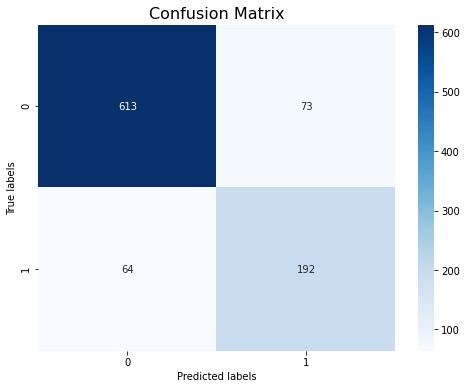

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       686
           1       0.72      0.75      0.74       256

    accuracy                           0.85       942
   macro avg       0.81      0.82      0.82       942
weighted avg       0.86      0.85      0.86       942

MCC Score=0.637


In [69]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### SMOTE

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Done training in 317.1852345466614 seconds.
Best Parameter:  {'svc__C': 0.05000000000000001}
Mean Test Score:  0.5616444875557564
Sd Test Score:  0.19170260592553123


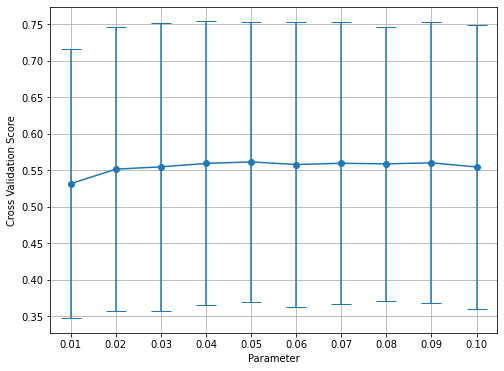

In [73]:
imba_pipeline = make_pipeline(SMOTE(random_state=0), SVC(random_state = 0))
start_time = time.time()
kf = GroupKFold(n_splits=10)
group = df.iloc[X_train.index]['Info_PepID'].values
params = {'C': np.linspace(0.01,0.1,10)}
new_params = {'svc__' + key: params[key] for key in params}
clf = GridSearchCV(imba_pipeline, param_grid=new_params, cv=kf, scoring=ftwo_scorer,n_jobs=-1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_svc__C'].data
# collect test scores
results['test'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (8, 6)
plt.xticks(results['parameter'].astype(np.float))
plt.errorbar(results['parameter'].astype(np.float), results['test'], yerr=clf.cv_results_['std_test_score'], fmt='-o', capsize = 10)
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


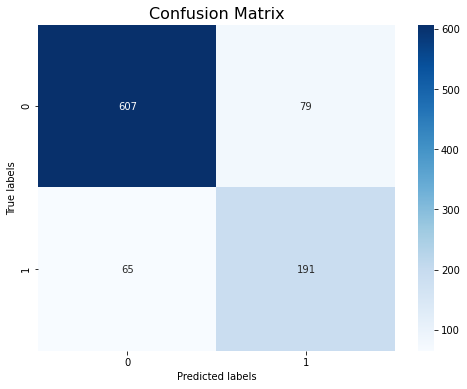

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       686
           1       0.71      0.75      0.73       256

    accuracy                           0.85       942
   macro avg       0.81      0.82      0.81       942
weighted avg       0.85      0.85      0.85       942

MCC Score=0.621


In [75]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

## XGBoost

### Baseline Model

Done training in 262.32700204849243 seconds.
Best Parameter:  {'max_depth': 2}
Mean Test Score:  0.5225263930150034
Sd Test Score:  0.1639875428010875


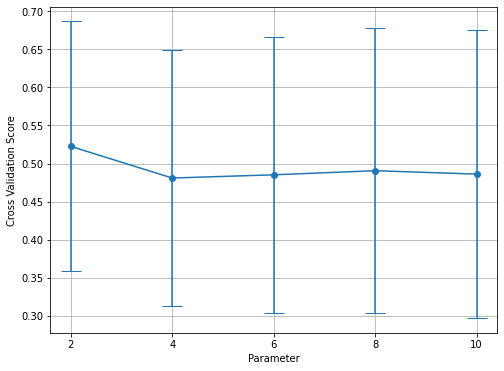

In [76]:
model = xgb.XGBClassifier(random_state=0)
start_time = time.time()
kf = GroupKFold(n_splits=10)
group = df.iloc[X_train.index]['Info_PepID'].values
xgbparams = {'max_depth': [2, 4, 6, 8, 10]}
clf = GridSearchCV(model, xgbparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_max_depth'].data
# collect test scores
results['test'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (8, 6)
plt.xticks(results['parameter'].astype(np.float))
plt.errorbar(results['parameter'].astype(np.float), results['test'], yerr=clf.cv_results_['std_test_score'], fmt='-o', capsize = 10)
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print('Best Parameter: ', clf.best_params_)
print('Mean Test Score: ', clf.best_score_)
print('Sd Test Score: ', clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


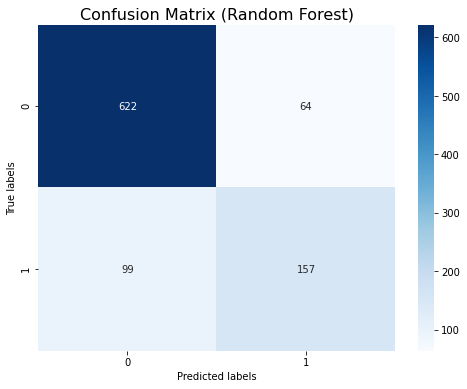

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       686
           1       0.71      0.61      0.66       256

    accuracy                           0.83       942
   macro avg       0.79      0.76      0.77       942
weighted avg       0.82      0.83      0.82       942

MCC Score=0.546


In [ ]:
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

### Cost Sensitive

In [ ]:
cls_weight = (y_train.shape[0] - np.sum(y_train)) / np.sum(y_train)
ftwo_scorer = make_scorer(matthews_corrcoef)
model = xgb.XGBClassifier(scale_pos_weight=cls_weight, random_state=0)
start_time = time.time()
kf = StratifiedKFold(n_splits=5)
svcparams = {'C': [0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5]} 
clf = GridSearchCV(model, svcparams, scoring=ftwo_scorer, cv = kf, n_jobs=-1).fit(X_train,y_train)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_C'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

## Neural Network

After the feature engineering this is the next largest amount of work.

I started with a couple of layers (64/31/1) and appropriate model parameters.

The problem is a binary classification which means we use binary_crossentropy as the loss and sigmoid activation on the last layer.
Optimizer is rmsprop (TODO: check other optimizers)

I then iterated over hyperparams to find the best values, tuning each section before moving to the next:

*   Layers
*   Number of epochs
*   Batch size
*   Regularization

Then back through the loop to make sure the later settings hadn't changed the initial tunings.

In [ ]:
# Defining the custom metric of Matthew Correlation Coefficient
def mcc(y_true, y_pred):
   y_pred_pos = K.round(K.clip(y_pred, 0, 1))
   y_pred_neg = 1 - y_pred_pos

   y_pos = K.round(K.clip(y_true, 0, 1))
   y_neg = 1 - y_pos

   tp = K.sum(y_pos * y_pred_pos)
   tn = K.sum(y_neg * y_pred_neg)

   fp = K.sum(y_neg * y_pred_pos)
   fn = K.sum(y_pos * y_pred_neg)

   numerator = (tp * tn - fp * fn)
   denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

   return numerator / (denominator + K.epsilon())

In [ ]:
def buildmodel():
  #Initialising the neural network
  classifier = Sequential()

  # Adding the input layer and the first hidden layer
  classifier.add(Dense(units = 256, kernel_initializer = 'uniform', activation = 'relu', input_dim = 205))

  # Adding the second hidden layer
  classifier.add(Dense(units = 128, kernel_initializer = 'uniform', activation = 'relu'))

  # Adding the third hidden layer
  classifier.add(Dense(units = 64, kernel_initializer = 'uniform', activation = 'relu'))

  # Adding the output layer
  classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

  # Compiling the ANN
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [mcc])

  return(classifier)

In [ ]:
kf = GroupKFold(n_splits=5)
group = df.iloc[X_train.index]['Info_PepID'].values
model = KerasClassifier(build_fn = buildmodel, verbose=1, epochs=50)
nnparams = {"batch_size": [50,100,150]}
start_time = time.time()
clf = GridSearchCV(model, nnparams, scoring = ftwo_scorer, cv = kf, n_jobs=-1, verbose=1).fit(X_train, y_train, groups=group)
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.8min finished


Epoch 1/50
27/27 [==============================] - 1s 5ms/step - loss: 0.6319 - mcc: 0.0026
Epoch 2/50
27/27 [==============================] - 0s 5ms/step - loss: 0.3014 - mcc: 0.7804
Epoch 3/50
27/27 [==============================] - 0s 5ms/step - loss: 0.1260 - mcc: 0.9012
Epoch 4/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0877 - mcc: 0.9058
Epoch 5/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0683 - mcc: 0.9316
Epoch 6/50
27/27 [==============================] - 0s 6ms/step - loss: 0.0608 - mcc: 0.9245
Epoch 7/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0526 - mcc: 0.9279
Epoch 8/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0545 - mcc: 0.9240
Epoch 9/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0477 - mcc: 0.9365
Epoch 10/50
27/27 [==============================] - 0s 5ms/step - loss: 0.0474 - mcc: 0.9247
Epoch 11/50
27/27 [==============================] - 0s 5ms/step - lo

{'batch_size': 150}
0.3654701105363953
0.051779749892639504


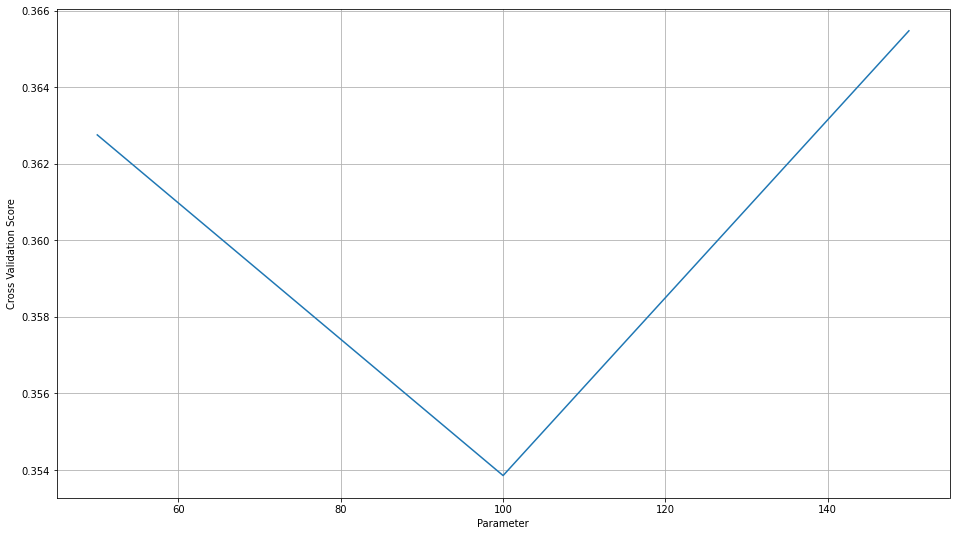

In [ ]:
results = pd.DataFrame()
# collect parameter list
results['parameter'] = clf.cv_results_['param_batch_size'].data
# collect test scores
results['score'] = clf.cv_results_['mean_test_score'].data

plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(results['parameter'], results['score'])
plt.xlabel('Parameter')
plt.ylabel('Cross Validation Score')
plt.grid()

print(clf.best_params_)
print(clf.best_score_)
print(clf.cv_results_['std_test_score'][clf.best_index_])

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 0s 3ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


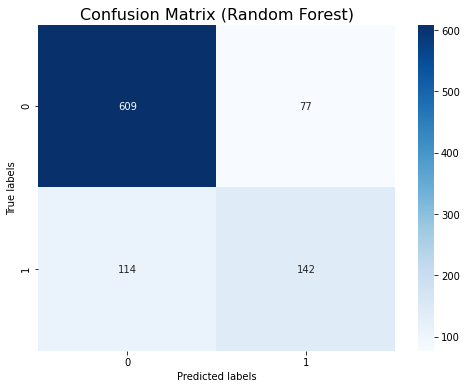

              precision    recall  f1-score   support

           0       0.84      0.89      0.86       686
           1       0.65      0.55      0.60       256

    accuracy                           0.80       942
   macro avg       0.75      0.72      0.73       942
weighted avg       0.79      0.80      0.79       942

MCC Score=0.466


In [ ]:
# make class predictions with the model
preds = clf.predict(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

Using matthews correlation coefficient, compares how many we predicted correctly compared to how many predicted incorrectly.
A more useful measure than binary_crossentropy due to the weighted dataset we have.

In [ ]:
classifier = buildmodel()
es = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=1)
start_time = time.time()
model = classifier.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 50, epochs = 100, verbose=0, callbacks=[es])
train_time = time.time() - start_time
print('Done training in', train_time, 'seconds.')

Epoch 00021: early stopping
Done training in 6.172859191894531 seconds.


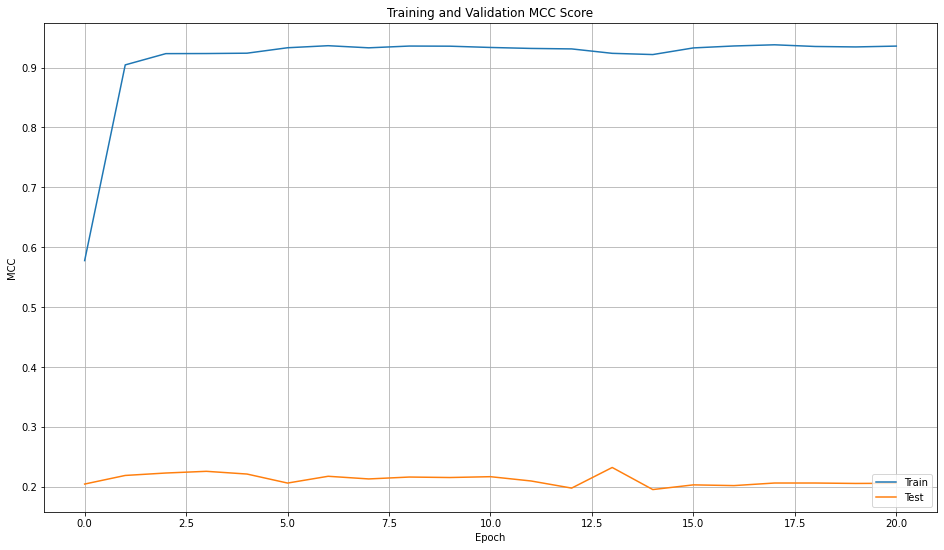

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(model.history['mcc'])
plt.plot(model.history['val_mcc'])

plt.title('Training and Validation MCC Score')
plt.ylabel('MCC')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

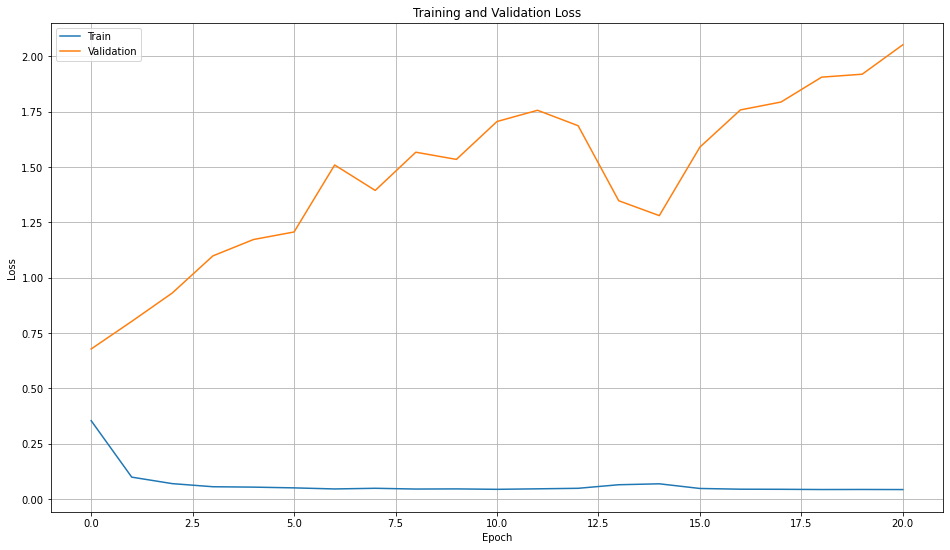

In [ ]:
plt.rcParams['figure.figsize'] = (16, 9)
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])

plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid()
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


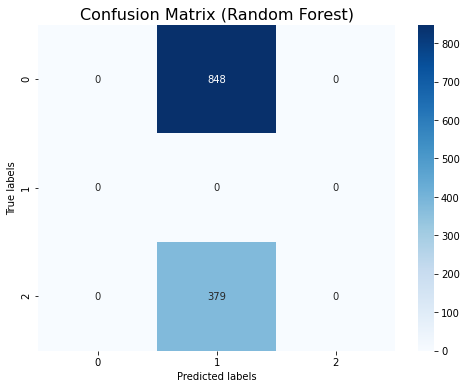

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     848.0
           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00     379.0

    accuracy                           0.00    1227.0
   macro avg       0.00      0.00      0.00    1227.0
weighted avg       0.00      0.00      0.00    1227.0

MCC Score=0.000


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [ ]:
# make class predictions with the model
preds = classifier.predict_classes(X_test)

# Evaluate
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
plt.title('Confusion Matrix (Random Forest)', size=16)
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

print(classification_report(y_test.astype(str),preds.astype(str)))

print('MCC Score=%.3f' % matthews_corrcoef(y_test, preds))

## Model Selection